# Continuous gene expression gradients in the cerebellum

Requirements: (1) UMI count matrix, (2) spatial location matrix.

In [1]:
import sys
import os
from collections import defaultdict
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from glmpca import glmpca
from itertools import combinations
import torch

import sys
from importlib import reload

import gaston
from gaston import neural_net,cluster_plotting, dp_related, segmented_fit
from gaston import binning_and_plotting, isodepth_scaling, run_slurm_scripts
from gaston import spatial_gene_classification, plot_cell_types, filter_genes, process_NN_output

import seaborn as sns
import math

## Step 1: Pre-processing

GASTON requires: 
- N x G counts matrix
- N x 2 spatial coordinate matrix,
- list of names for each gene

where N=number of spatial locations and G=number of genes

We run GLMPCA to compute the top PCs (one could use PCA instead but the factors often look worse)

In [16]:
!mkdir -p cerebellum_tutorial_outputs

In [17]:
counts_mat=np.load('cerebellum_data/cerebellum_counts_mat.npy') # N x G UMI count array
coords_mat=np.load('cerebellum_data/cerebellum_coords_mat.npy') # N x 2 spatial coordinate matrix
gene_labels=np.load('cerebellum_data/cerebellum_gene_labels.npy', allow_pickle=True) # list of names for G genes

In [58]:
num_dims=8 # 2 * number of clusters
penalty=10 # may need to increase if this is too small

glmpca_res=glmpca.glmpca(counts_mat.T, num_dims, fam="poi", penalty=penalty, verbose=True)
A = glmpca_res['factors'] # should be of size N x num_dims, where each column is a PC

np.save('cerebellum_data/glmpca.npy', A)

Iteration: 0 | deviance=2.4128E+7
Iteration: 1 | deviance=2.4128E+7
Iteration: 2 | deviance=2.3962E+7
Iteration: 3 | deviance=2.3129E+7
Iteration: 4 | deviance=2.2833E+7
Iteration: 5 | deviance=2.2696E+7
Iteration: 6 | deviance=2.2606E+7
Iteration: 7 | deviance=2.2544E+7
Iteration: 8 | deviance=2.2499E+7
Iteration: 9 | deviance=2.2464E+7
Iteration: 10 | deviance=2.2437E+7
Iteration: 11 | deviance=2.2414E+7
Iteration: 12 | deviance=2.2394E+7
Iteration: 13 | deviance=2.2377E+7
Iteration: 14 | deviance=2.2363E+7
Iteration: 15 | deviance=2.2350E+7
Iteration: 16 | deviance=2.2338E+7
Iteration: 17 | deviance=2.2328E+7
Iteration: 18 | deviance=2.2319E+7
Iteration: 19 | deviance=2.2311E+7
Iteration: 20 | deviance=2.2304E+7
Iteration: 21 | deviance=2.2298E+7
Iteration: 22 | deviance=2.2293E+7
Iteration: 23 | deviance=2.2288E+7
Iteration: 24 | deviance=2.2284E+7
Iteration: 25 | deviance=2.2280E+7
Iteration: 26 | deviance=2.2277E+7
Iteration: 27 | deviance=2.2274E+7
Iteration: 28 | deviance=2.227

ValueError: 'c' argument has 23096 elements, which is inconsistent with 'x' and 'y' with size 9985.

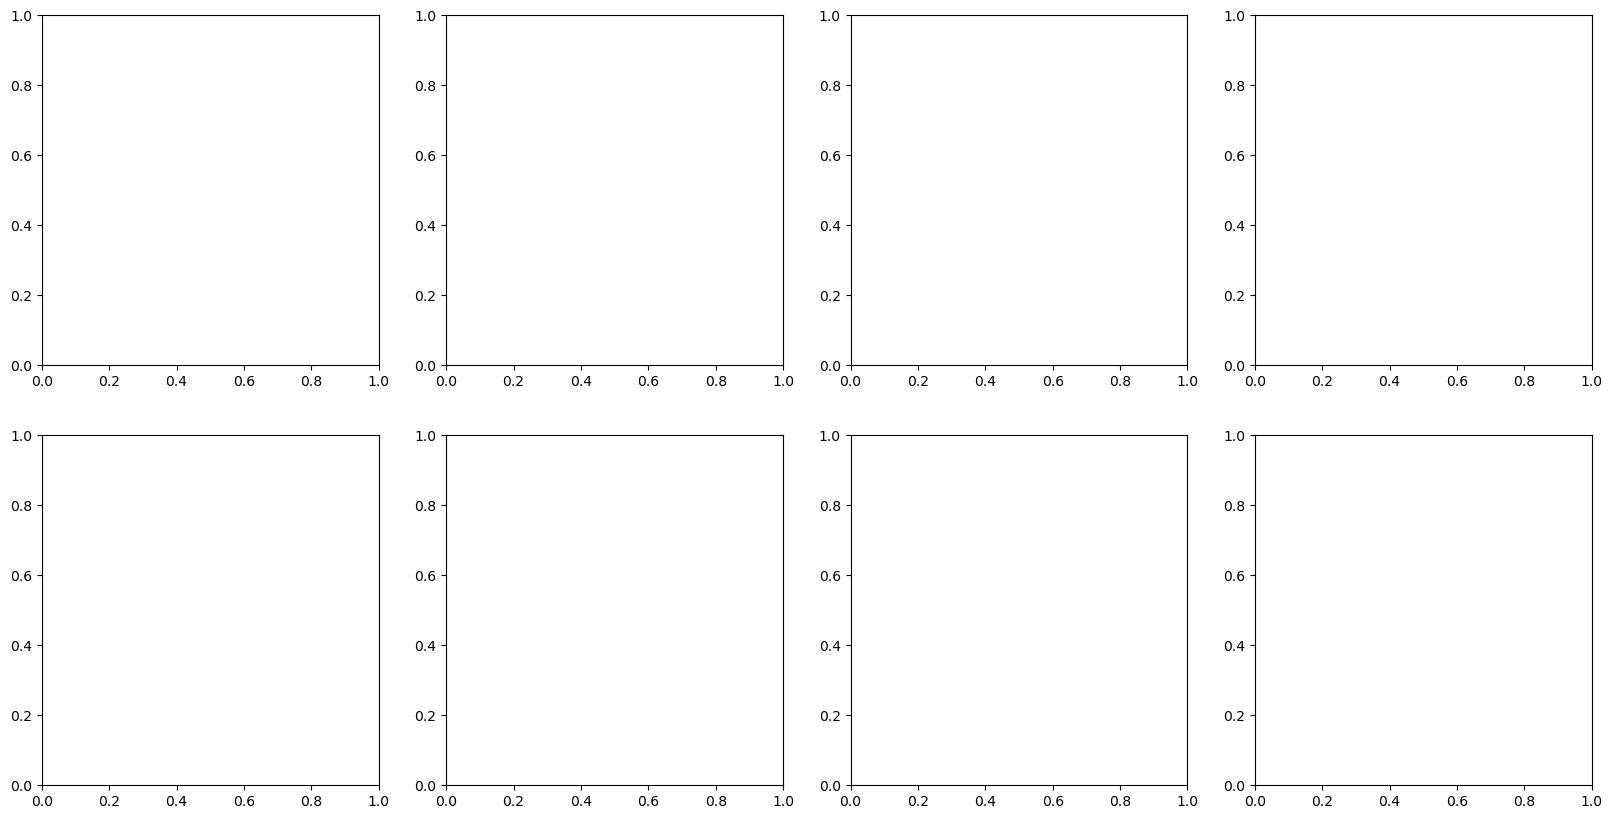

In [60]:
# visualize top GLM-PCs
R=2
C=4
fig,axs=plt.subplots(R,C,figsize=(20,10))
for r in range(R):
    for c in range(C):
        i=r*C+c
        axs[r,c].scatter(coords_mat[:,0], coords_mat[:,1], c=A[:,i],cmap='Reds',s=3)
        axs[r,c].set_title(f'GLM-PC{i}')

In [56]:
print(A.shape)

(23096, 8)


## Step 2: Train GASTON neural network

We include how to train the neural network with two options: (1) a command line script and (2) in a notebook. We typically train the neural network 30 different times, each with a different seed, and we use the NN with lowest loss. 

### Option 1: Slurm (Recommended)

For option (1), the code below creates 30 different Slurm jobs, one for each initialization. To train the NN for a single initialization run the following command:

`gaston -i /path/to/coords.npy -o /path/to/glmpca.npy -d /path/to/output_dir -e 10000 -c 500 -p 20 20 -x 20 20 -z adam -s SEED`

for a given `SEED` value (integer)

In [19]:
# path_to_coords='cerebellum_data/cerebellum_coords_mat.npy'
# path_to_glmpca='tutorial_outputs/glmpca.npy'

# To approximately recreate paper figures, use same GLM-PCs from paper 
path_to_coords='cerebellum_data/cerebellum_coords_mat.npy'
path_to_glmpca='cerebellum_data/F_glmpca_penalty_10_rep1.npy' # for the GLM-PCs from paper

# GASTON NN parameters
isodepth_arch=[20,20] # architecture (two hidden layers of size 20) for isodepth neural network d(x,y)
expression_arch=[20,20] # architecture (two hidden layers of size 20) for 1-D expression function
epochs = 10000 # number of epochs to train NN
checkpoint = 500 # save model after number of epochs = multiple of checkpoint
optimizer = "adam"
num_restarts=30 # number of initializations

output_dir='cerebellum_tutorial_outputs' # folder to save model runs

# REPLACE with your own conda environment name and path
conda_environment='gaston-package'
path_to_conda_folder='/n/fs/ragr-research/users/jh3258/miniconda3/bin/activate'
partition='raphael' # if you have a separate partition on the cluster

run_slurm_scripts.train_NN_parallel(path_to_coords, path_to_glmpca, isodepth_arch, expression_arch, 
                      output_dir, conda_environment, path_to_conda_folder,
                      epochs=epochs, checkpoint=checkpoint, 
                      num_seeds=num_restarts, partition=partition)

jobId: 19724772
jobId: 19724773
jobId: 19724774
jobId: 19724775
jobId: 19724776
jobId: 19724777
jobId: 19724778
jobId: 19724779
jobId: 19724780
jobId: 19724781
jobId: 19724782
jobId: 19724783
jobId: 19724784
jobId: 19724785
jobId: 19724786
jobId: 19724787
jobId: 19724788
jobId: 19724789
jobId: 19724790
jobId: 19724791
jobId: 19724792
jobId: 19724793
jobId: 19724794
jobId: 19724795
jobId: 19724796
jobId: 19724797
jobId: 19724798
jobId: 19724799
jobId: 19724800
jobId: 19724801


Wait for models to finish training. You can check on their status by running `squeue -u uchitra`  -- replacing `uchitra` with your username

### Option 2: train in notebook

We first load GLM-PCs and coordinates and z-score normalize.

In [289]:
# Load N x G matrix A of GLM-PCs, and N x 2 matrix S
# A=np.load('tutorial_outputs/glmpca.npy') # GLM-PCA results from above
A=np.load('data/cerebellum/F_glmpca_penalty_10_rep1.npy') # GLM-PCA results used in manuscript
S=coords_mat

# z-score normalize S and A
S_torch, A_torch = neural_net.load_rescale_input_data(S,A)

Next we train the neural network, once for each random initialization.

In [260]:
######################################
# NEURAL NET PARAMETERS (USER CAN CHANGE)
# architectures are encoded as list, eg [20,20] means two hidden layers of size 20 hidden neurons
isodepth_arch=[20,20] # architecture for isodepth neural network d(x,y) : R^2 -> R 
expression_fn_arch=[20,20] # architecture for 1-D expression function h(w) : R -> R^G

num_epochs = 10000 # number of epochs to train NN (NOTE: it is sometimes beneficial to train longer)
checkpoint = 500 # save model after number of epochs = multiple of checkpoint
out_dir='tutorial_outputs' # folder to save model runs
optimizer = "adam"
num_restarts=30

######################################

seed_list=range(num_restarts)
for seed in seed_list:
    print(f'training neural network for seed {seed}')
    out_dir_seed=f"{out_dir}/rep{seed}"
    os.makedirs(out_dir_seed, exist_ok=True)
    mod, loss_list = neural_net.train(S_torch, A_torch,
                          S_hidden_list=isodepth_arch, A_hidden_list=expression_fn_arch, 
                          epochs=num_epochs, checkpoint=checkpoint, 
                          save_dir=out_dir_seed, optim=optimizer, seed=seed, save_final=True)

training neural network for seed 19


## Step 3: Process neural network output

If you use the model trained above, then figures will closely match the manuscript --- but not exactly match --- due to PyTorch non-determinism in seeding (see https://github.com/pytorch/pytorch/issues/7068 ). 

We also include the model used in the paper for reproducibility.

### Visualize isodepth (topographic map) and spatial domains

Load best model

In [21]:
# gaston_model, A, S= process_NN_output.process_files('cerebellum_tutorial_outputs')
gaston_model, A, S= process_NN_output.process_files('cerebellum_data/reproduce_cerebellum') # TO MATCH PAPER FIGURES

# may need to re-load counts_mat, coords_mat, gene_labels from previous step
counts_mat=np.load('cerebellum_data/cerebellum_counts_mat.npy') # N x G UMI count array
coords_mat=np.load('cerebellum_data/cerebellum_coords_mat.npy') # N x 2 spatial coordinate matrix
gene_labels=np.load('cerebellum_data/cerebellum_gene_labels.npy', allow_pickle=True) # list of names for G genes

best model: cerebellum_data/reproduce_cerebellum/seed19


Compute isodepth and gaston labels from model

In [22]:
num_layers=4
gaston_isodepth, gaston_labels=dp_related.get_isodepth_labels(gaston_model,A,S,num_layers)

# DATASET-SPECIFIC: so domains are ordered oligodendrocyte to molecular, with increasing isodepth
gaston_isodepth=np.max(gaston_isodepth) - gaston_isodepth
gaston_labels=(num_layers-1)-gaston_labels

OPTIONAL: Scale isodepth to approximately reflect physical distances.

NOTE: `q_vals=[0.2, 0.05, 0.15, 0.3]` was manually chosen for the cerebellum 
you may omit the argument for other datasets (automatically uses 0.05)

In [23]:
scale_factor=64/100 # since 64 pixels = 100 microns in slide-seq image

# WITH VISUALIZATION
# gaston_isodepth=isodepth_scaling.adjust_isodepth(gaston_isodepth, gaston_labels, coords_mat, 
#                                  q_vals=[0.2, 0.05, 0.15, 0.3], visualize=True, figsize=(12,12),num_rows=2)

# WITHOUT
gaston_isodepth=isodepth_scaling.adjust_isodepth(gaston_isodepth, gaston_labels, coords_mat, 
                                 q_vals=[0.2, 0.05, 0.15, 0.3], scale_factor=scale_factor)

Topographic map of isodepth + contours

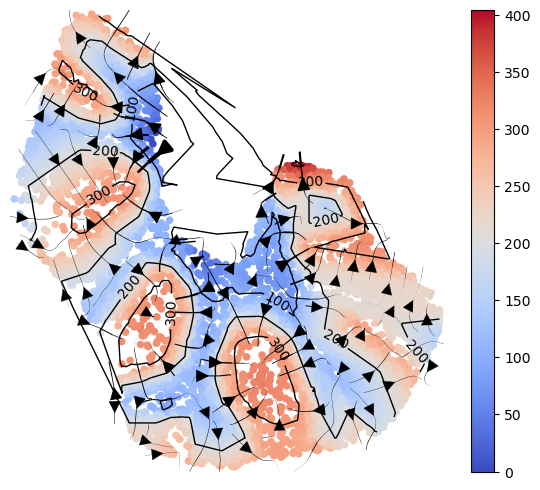

In [24]:
show_streamlines=True
cluster_plotting.plot_isodepth(gaston_isodepth, S, gaston_model, figsize=(7,6), streamlines=show_streamlines)

Spatial domains

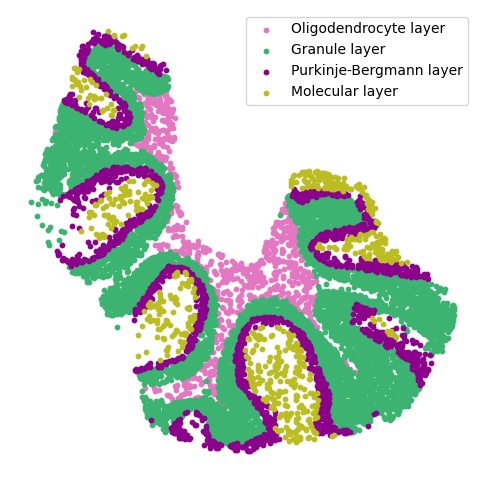

In [25]:
labels=['Oligodendrocyte layer', 'Granule layer', 'Purkinje-Bergmann layer', 'Molecular layer']

# WITHOUT CUSTOM COLORS
# cluster_plotting.plot_clusters(gaston_labels, S, figsize=(6,6), colors=None, 
#                                color_palette=plt.cm.Dark2, s=10,labels=labels,lgd=True)

# TO PLOT WITH CUSTOM COLORS:
domain_colors=['C6', 'mediumseagreen', 'darkmagenta', 'C8']
cluster_plotting.plot_clusters(gaston_labels, S, figsize=(6,6), 
                               colors=domain_colors, s=10,labels=labels,lgd=True)

### Plot cell type vs isodepth (if cell type info available)

Load cell type label per spot (from RCTD). We store as N x C dataframe M where M[i,c]=1 if spot i is cell type c, and 0 if not

In [26]:
cell_type_df=pd.read_csv('cerebellum_data/cell_type_df.csv', index_col=0)
cell_type_df

,Astrocytes,Bergmann,Candelabrum,Choroid,Endothelial,Ependymal,Fibroblast,Globular,Golgi,Granule,Lugaro,MLI1,MLI2,Macrophages,Microglia,Oligodendrocytes,Polydendrocytes,Purkinje,UBCs
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9981,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9983,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0


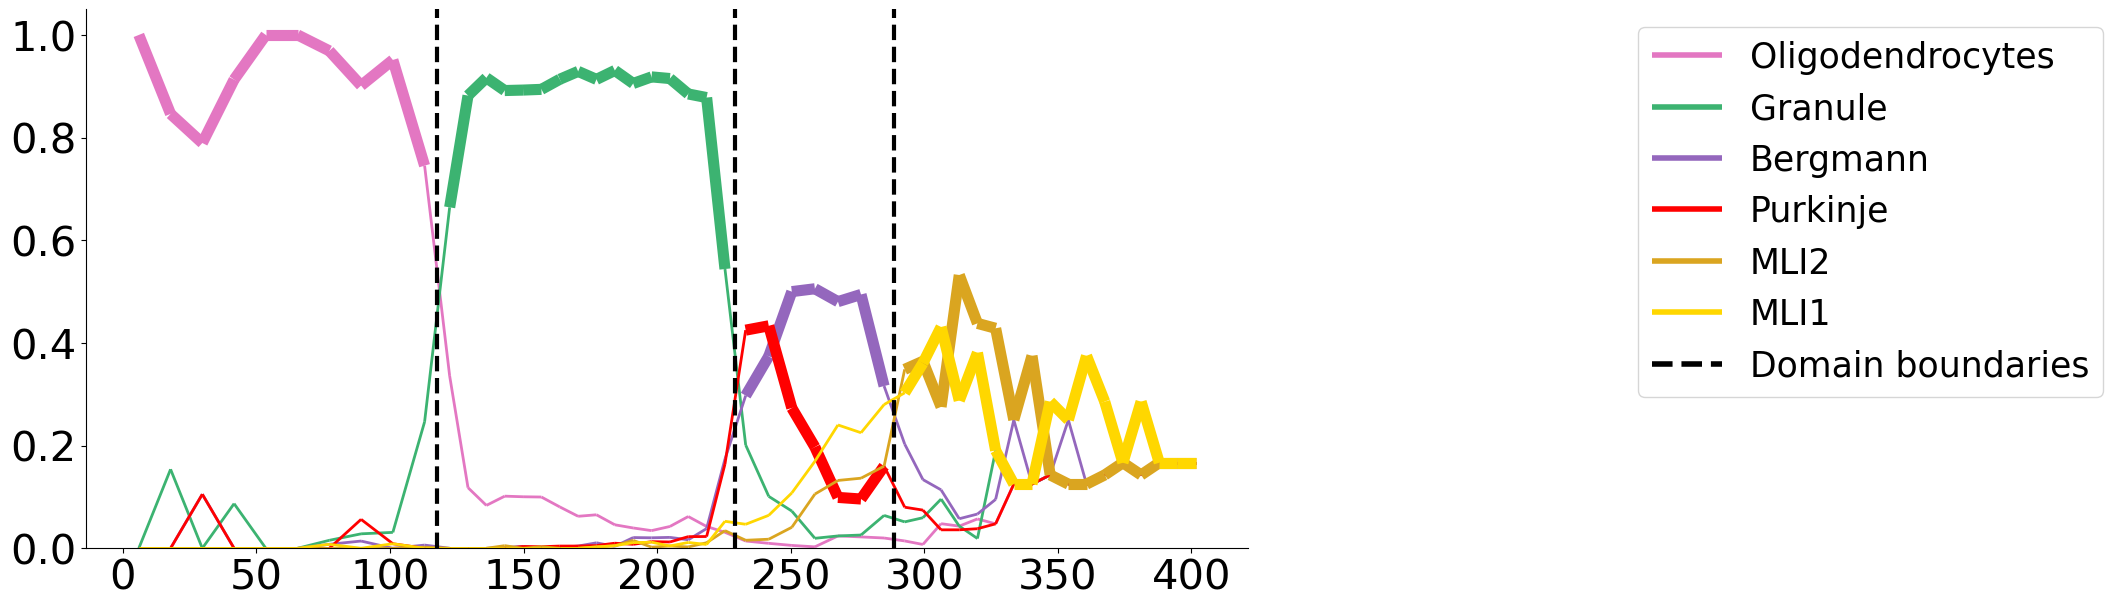

In [35]:
ct_colors={'Oligodendrocytes': 'C6', 'Granule': 'mediumseagreen', 'Purkinje': 'red', 
           'Bergmann': 'C4', 'MLI1': 'gold', 'MLI2': 'goldenrod',  'Astrocytes': 'C0', 
           'Golgi': 'C9', 'Fibroblast': 'C5'}

plot_cell_types.plot_ct_props(cell_type_df, gaston_labels, gaston_isodepth, 
                              num_bins_per_domain=[10,16,7,17], ct_colors=ct_colors, ct_pseudocounts={3:1}, 
                              include_lgd=True, figsize=(15,7), ticksize=30, width1=8, width2=2, 
                              domain_ct_threshold=0.5)

### Spatially varying gene analysis

In [36]:
domain_colors=['C6', 'mediumseagreen', 'darkmagenta', 'C8'] # layers: oligodendrocyte, granule, P-B, mol layers

ct_colors={'Oligodendrocytes': 'C6', 'Granule': 'mediumseagreen', 'Purkinje': 'red', 
           'Bergmann': 'C4', 'MLI1': 'gold', 'MLI2': 'goldenrod',  'Astrocytes': 'C0', 
           'Golgi': 'C9', 'Fibroblast': 'C5'}

Compute piecewise linear fit for every gene 

In [48]:
# Cell types for which to compute cell type-specific expression functions.
ct_list=['Oligodendrocytes', 'Granule', 'Bergmann', 'Purkinje', 'MLI1', 'MLI2']
# ct_list=[] # FOR SPEED, if you don't care about cell type specific effects or don't have cell type dict

# if you want to get rid of warnings
import warnings
warnings.filterwarnings("ignore")

# Piecewise linear fit parameters
t=0.1 # set slope=0 if LLR p-value > 0.1
umi_threshold=500 # only compute fit for genes with total UMI > 500
zero_fit_threshold=75 # only compute fit for (gene, domain) where gene has at least 75 UMIs in domain

pw_fit_dict=segmented_fit.pw_linear_fit(counts_mat, gaston_labels, gaston_isodepth, 
                                          cell_type_df, ct_list, zero_fit_threshold=zero_fit_threshold,
                                        t=t,umi_threshold=umi_threshold,
                                       isodepth_mult_factor=0.1) # isodepth_mult_factor for stability, if range of isodepth values is too large

Poisson regression for ALL cell types


  0%|          | 0/3389 [00:00<?, ?it/s]


ValueError: Input y contains NaN.

In [31]:
binning_output=binning_and_plotting.bin_data(counts_mat, gaston_labels, gaston_isodepth, 
                         cell_type_df, gene_labels, num_bins_per_domain=[5,10,5,5], umi_threshold=umi_threshold)

In [47]:
for x in ct_list:
    if np.isnan(x):
        print("YO")

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

Find discontinuous and continuous genes and visualize piecewise linear fits 

In [32]:
q=0.9 # use 0.9 quantile for slopes, discontinuities
discont_genes_layer=spatial_gene_classification.get_discont_genes(pw_fit_dict, binning_output,q=q)
cont_genes_layer=spatial_gene_classification.get_cont_genes(pw_fit_dict, binning_output,q=q)

NameError: name 'pw_fit_dict' is not defined

In [33]:
gene_name='Frmpd4'
print(f'gene {gene_name}: discontinuous after domain(s) {discont_genes_layer[gene_name]}') 
print(f'gene {gene_name}: continuous in domain(s) {cont_genes_layer[gene_name]}')

# display log CPM (if you want to do CP500, set offset=500)
offset=10**6

binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels, gaston_isodepth, 
                                        binning_output, cell_type_list=None, pt_size=50, colors=domain_colors, 
                                        linear_fit=True, ticksize=15, figsize=(4,2.5), offset=offset, lw=3,
                                       domain_boundary_plotting=True)

NameError: name 'discont_genes_layer' is not defined

gene Sbk1: large discontinuous jump after domain(s) []
gene Sbk1: large continuous gradient in domain(s) [1]


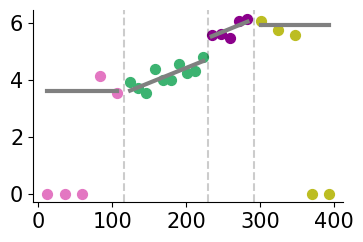

In [23]:
gene_name='Sbk1'
print(f'gene {gene_name}: large discontinuous jump after domain(s) {discont_genes_layer[gene_name]}') 
print(f'gene {gene_name}: large continuous gradient in domain(s) {cont_genes_layer[gene_name]}')

# display log CPM (if you want to do CP500, set offset=500)
offset=10**6

binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels, gaston_isodepth, 
                                        binning_output, cell_type_list=None, pt_size=50, colors=domain_colors, 
                                        linear_fit=True, ticksize=15, figsize=(4,2.5), offset=offset, lw=3,
                                       domain_boundary_plotting=True)

 Cell type-attributable and other intradomain variation

In [24]:
domain_cts=plot_cell_types.get_domain_cts(binning_output, 0.5) # layer-specific cell types
cont_genes_layer_ct=spatial_gene_classification.get_cont_genes(pw_fit_dict, binning_output,
                                                               ct_attributable=True, 
                                                              domain_cts=domain_cts,
                                                               q=0.9,
                                                              ct_perc=0.4)

gene Calb1, continuous gradients [(1, 'Granule'), (2, 'Bergmann')]


Text(0.5, 1.0, 'Granule only')

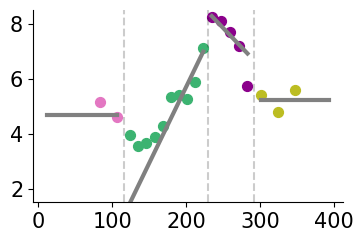

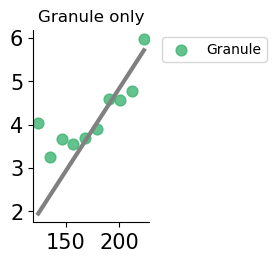

In [25]:
gene_name='Calb1'
print(f'gene {gene_name}, continuous gradients {cont_genes_layer_ct[gene_name]}')

binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels, gaston_isodepth, 
                                        binning_output, cell_type_list=None, pt_size=50, colors=domain_colors, 
                                        linear_fit=True, ticksize=15, figsize=(4,2.5), offset=10**6, lw=3,
                                       domain_boundary_plotting=True)
plt.ylim((1.5,8.5))

# show cell type-specific functions in domain 1 (granule)
domain=1
cts=domain_cts[domain]

binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels, gaston_isodepth, binning_output,
                                        cell_type_list=cts,ct_colors=ct_colors, spot_threshold=0.2, pt_size=60, 
                                        colors=domain_colors, linear_fit=True, domain_list=[domain],ticksize=15, 
                                        figsize=(1.5,2.5), offset=10**6, lw=3, alpha=0.8,show_lgd=True)
cts_list=' '.join(map(str, cts))
plt.title(f'{cts_list} only')

gene Camk1d, continuous gradients [(2, 'Bergmann'), (2, 'Purkinje'), (3, 'Other')]


Text(0.5, 1.0, 'MLI2 MLI1 only')

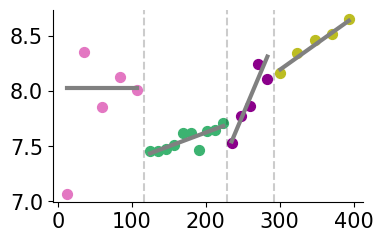

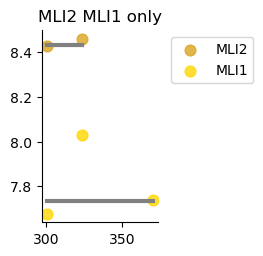

In [26]:
gene_name='Camk1d'
print(f'gene {gene_name}, continuous gradients {cont_genes_layer_ct[gene_name]}')

binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels, gaston_isodepth, 
                                        binning_output, cell_type_list=None, pt_size=50, colors=domain_colors, 
                                        linear_fit=True, ticksize=15, figsize=(4,2.5), offset=10**6, lw=3,
                                       domain_boundary_plotting=True)

# show cell type-specific functions in domain 3 (MLI)
domain=3
cts=domain_cts[domain]

binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels, gaston_isodepth, binning_output,
                                        cell_type_list=cts,ct_colors=ct_colors, spot_threshold=0.2, pt_size=60, 
                                        colors=domain_colors, linear_fit=True, domain_list=[domain],ticksize=10, 
                                        figsize=(1.5,2.5), offset=10**6, lw=3, alpha=0.8, show_lgd=True)
cts_list=' '.join(map(str, cts))
plt.title(f'{cts_list} only')